In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC, Predictive

import matplotlib.pyplot as plt

/home/soumik/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.manual_seed(42)

n = 100

mu_true = torch.tensor([25.0, 60.0, 1013.0, 0.02])

sigma_true = torch.tensor([2.0, 5.0, 8.0, 0.01])
cov_true = torch.diag(sigma_true ** 2)

x = dist.MultivariateNormal(mu_true, covariance_matrix = cov_true).sample((n,))

In [4]:
def model(data):
    # Prior mu
    mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(4), 100 * torch.eye(4)))

    # Prior sigma
    scale = pyro.sample("scale", dist.LogNormal(torch.zeros(4), torch.ones(4)))
    corr = torch.eye(4)

    L = torch.diag(scale) @ corr

    sigma = L @ L.T

    with pyro.plate("data", data.shape[0]):
        pyro.sample("obs", dist.MultivariateNormal(mu,covariance_matrix=sigma), obs = data)

In [5]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, warmup_steps=2000,num_chains=1)
mcmc.run(x)

Sample: 100%|██████████| 12000/12000 [03:35, 55.77it/s, step size=3.81e-01, acc. prob=0.934]


In [6]:
posterior_samples = mcmc.get_samples()

mu_samples = posterior_samples["mu"]
scale_samples = posterior_samples["scale"]

In [8]:
# Predictive Sampling
pred = Predictive(model, posterior_samples, num_samples=1000)
posterior_pred = pred(x)

x_pred_samples = posterior_pred["obs"]

/home/soumik/.local/lib/python3.10/site-packages/pyro/infer/predictive.py:206: UserWarning: Sample's leading dimension size 10000 is different from the provided 1000 num_samples argument. Defaulting to 10000.
  warnings.warn(


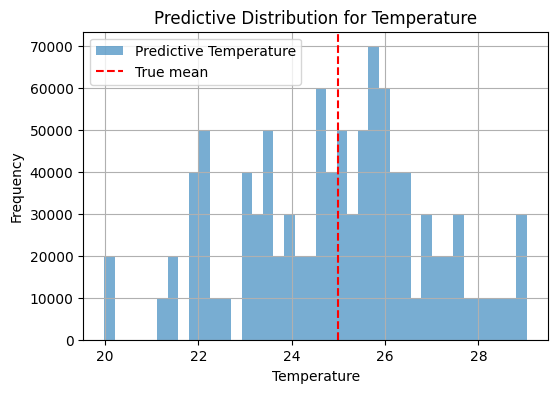

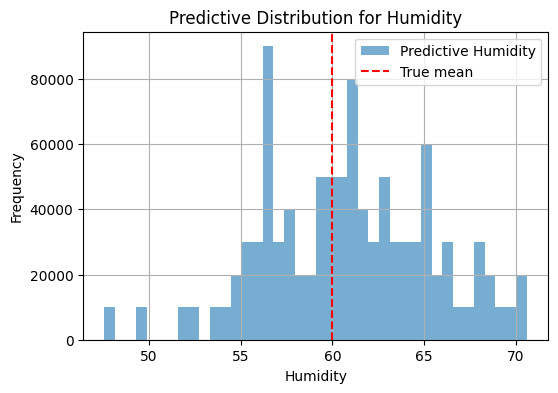

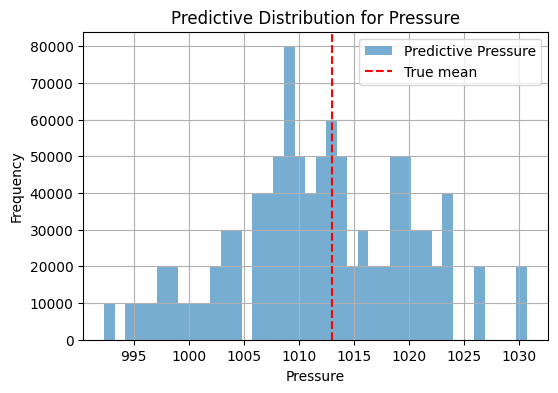

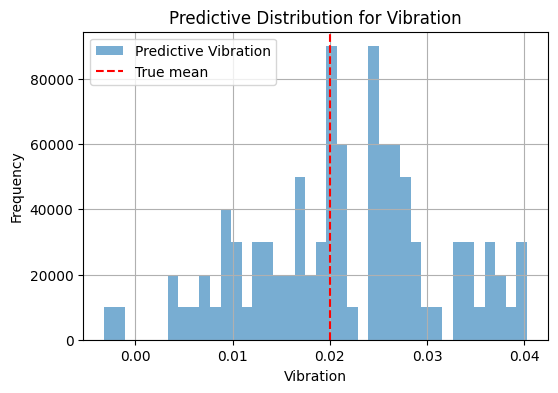

In [10]:
labels = ["Temperature", "Humidity", "Pressure", "Vibration"]

for i in range(4):
    plt.figure(figsize=(6, 4))
    plt.hist(x_pred_samples[:, :, i].reshape(-1).numpy(), bins=40, alpha=0.6, label=f"Predictive {labels[i]}")
    plt.axvline(mu_true[i].item(), color='r', linestyle='--', label="True mean")
    plt.title(f"Predictive Distribution for {labels[i]}")
    plt.xlabel(labels[i])
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()